<a href="https://colab.research.google.com/github/tiagoAG28/malaria_CNN/blob/main/malaria_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - 2024 / 2025

Grupo: Tiago Gomes


# Definition of the Problem

The primary objective of this project is the **classification of a cell** as either infected with malaria or not infected.

# Dependencies

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets.public_api as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.18.0


# Auxiliary functions /code




In [2]:
def count_n_images_iterator(this_iterator, name, what='images'):
    """
    Function to count the number of items (images/batches) in the dataset that
    is an iterator. Does not return. Prints a string.

    Input:
        this_iterator: tf.data.Dataset
            Iterator containing the data. TensorFlow Dataset.
        name: str
            Name of the dataset. Should be 'train','test','validation'
        what: str
            Specifies if we are dealing with single images or batches. Should
            be 'images' or 'batches'.

    Output:
        None
    """

    count_items = 0
    for item, label in this_iterator:
        count_items += 1

    print(f'The {name} dataset has {count_items} {what}.')

In [3]:
def plot_acuracy_loss(history):
    """
    Adapted from: https://www.tensorflow.org/tutorials/images/classification

    This function plots the training and validation accuracy and loss over a number of epochs.

    - It extracts the training/validation accuracy and loss from the 'history' dictionary.
    - It creates an epoch range (make sure 'epochs' is defined).
    - It then plots:
      * Training vs. Validation Accuracy
      * Training vs. Validation Loss
    - Finally, it displays the plots to help diagnose model performance.

    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Load Data

The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.

In [4]:
split0, split1, split2 = tfds.even_splits('train', n=3)

In [5]:
ds_train, ds_info = tfds.load(
    'malaria',
    split=split0,
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.L5QWVW_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [6]:
ds_test, __ = tfds.load(
    'malaria',
    split=split1,
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
    )

In [7]:
ds_val, __ = tfds.load(
    'malaria',
    split=split2,
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
    )

In [8]:
print(ds_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

## Explore the data


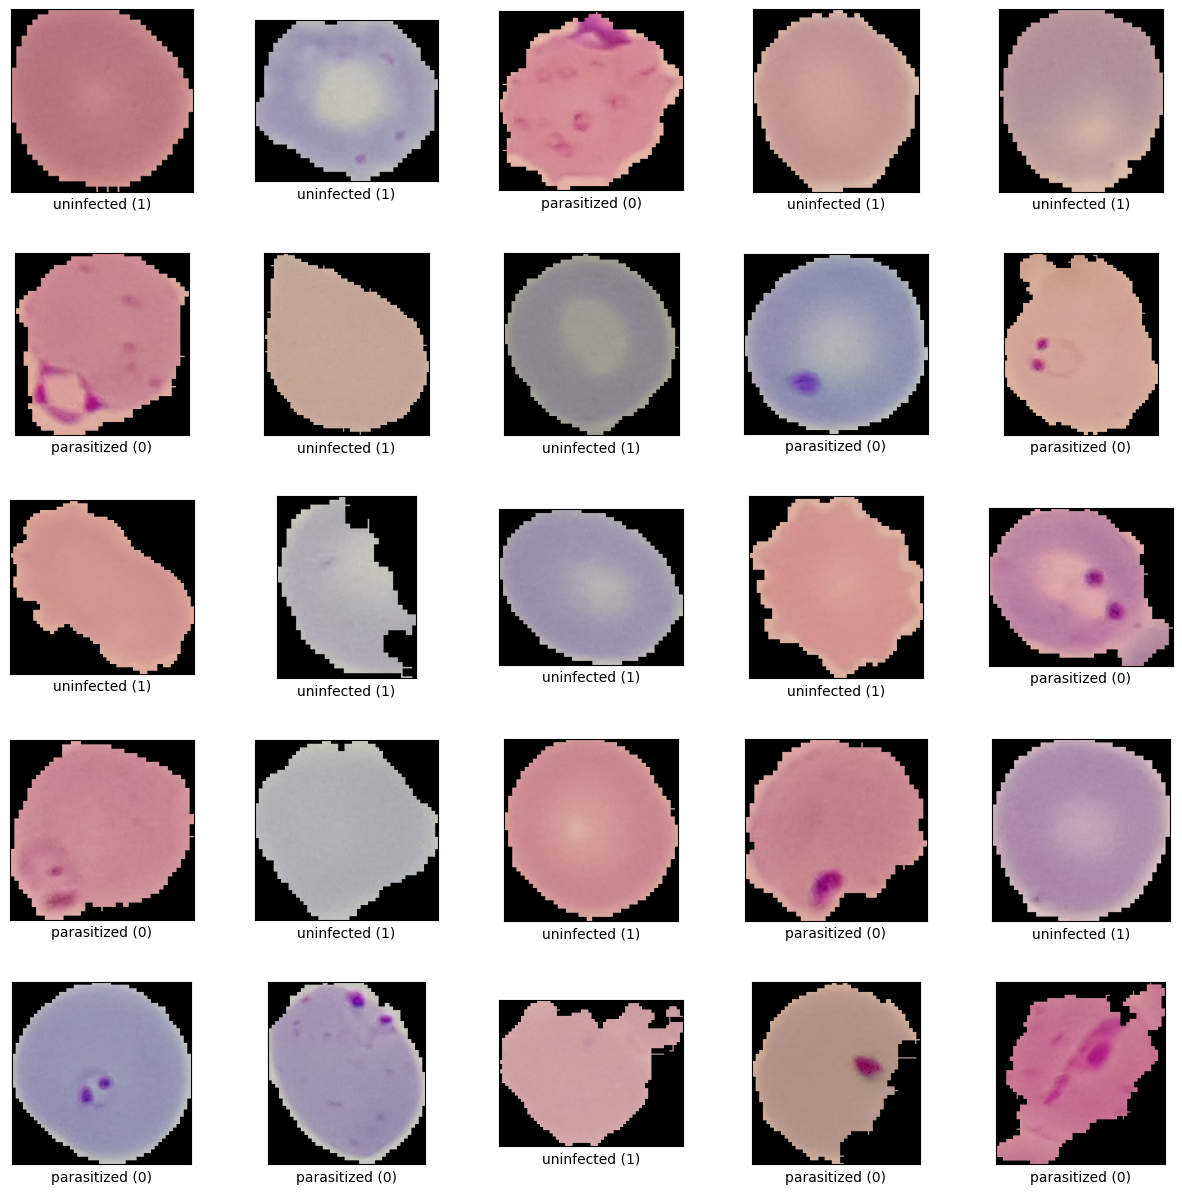

In [9]:
fig = tfds.show_examples(ds_train, ds_info, rows=5, cols=5)

In [10]:
count_n_images_iterator(ds_train, 'train'),
count_n_images_iterator(ds_test, 'test'),
count_n_images_iterator(ds_val, 'validation')

The train dataset has 9186 images.
The test dataset has 9186 images.
The validation dataset has 9186 images.


- The images have diferent sizes - we need to resize them to all have the same size
- Uninfected images are labeled as '1'
- Parasitazed images are labeled as '0'
- The dataset has color, therefore 3 channels.

# Data Preparation
### Normalization


In [11]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32) /255.0, label

In [12]:
normalize_ds_train = ds_train.map(normalize_image)
normalize_ds_test = ds_test.map(normalize_image)
normalize_ds_val = ds_val.map(normalize_image)

### Resize all the images

In [13]:
def resize_image(image, label, target_height=100, target_width=100):
    return tf.image.resize_with_pad(image, target_height, target_width), label

In [14]:
resized_ds_train = normalize_ds_train.map(resize_image)
resized_ds_test = normalize_ds_test.map(resize_image)
resized_ds_val = normalize_ds_val.map(resize_image)

In [15]:
count_n_images_iterator(resized_ds_train, 'train'),
count_n_images_iterator(resized_ds_test, 'test'),
count_n_images_iterator(resized_ds_val, 'validation')

The train dataset has 9186 images.
The test dataset has 9186 images.
The validation dataset has 9186 images.


## Data after transformation

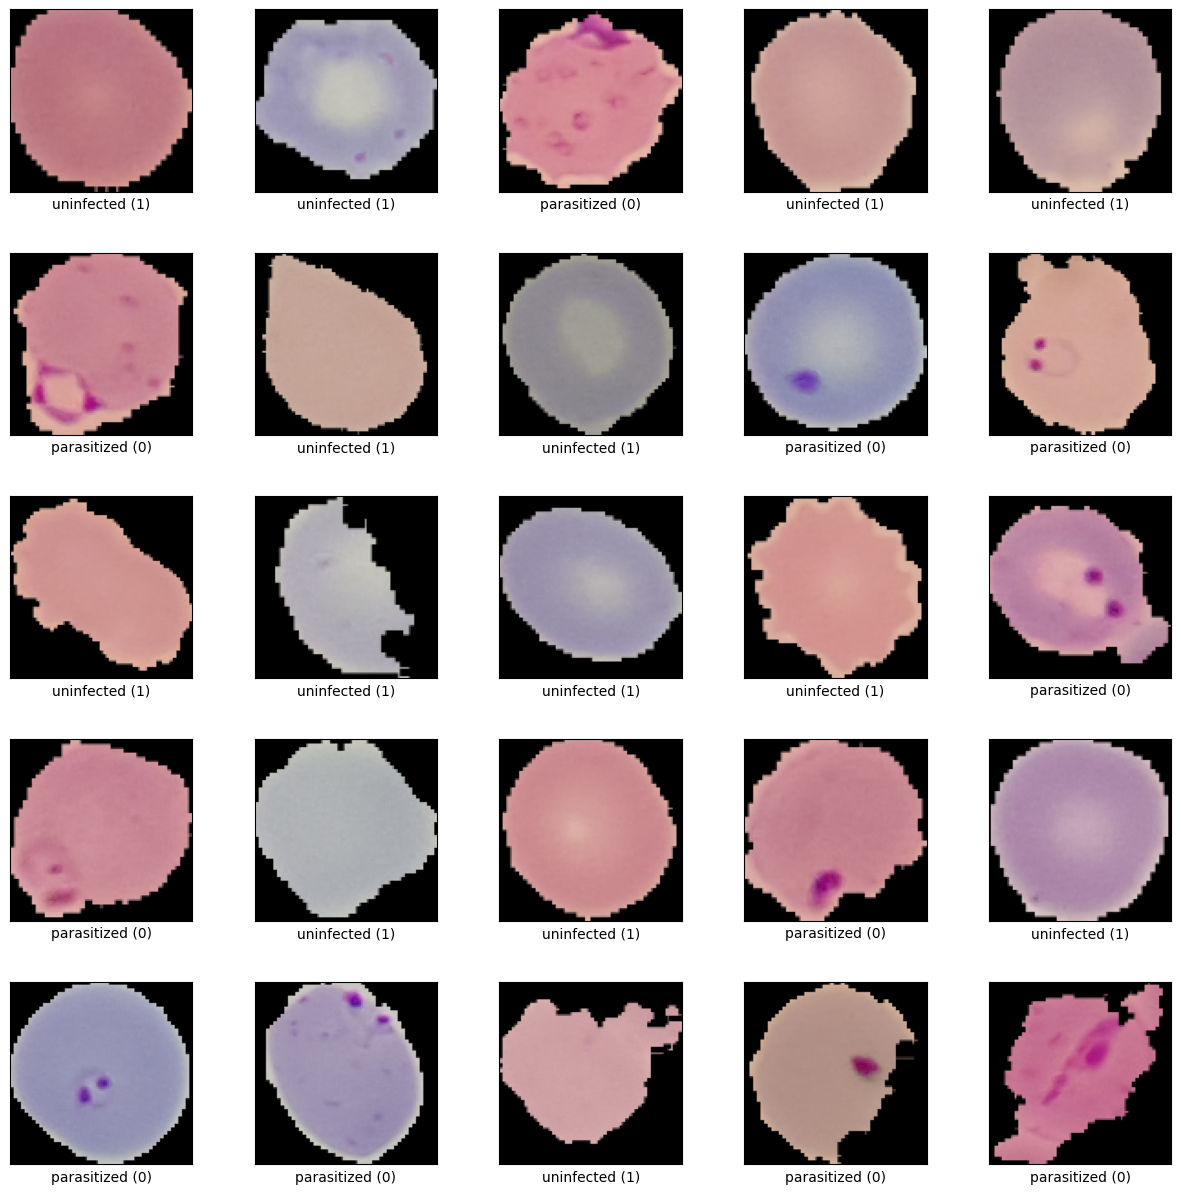

In [16]:
fig = tfds.show_examples(resized_ds_train, ds_info, rows=5, cols=5)

## Define batch size


In [17]:
resized_ds_train = resized_ds_train.batch(1024)
resized_ds_test = resized_ds_test.batch(1024)
resized_ds_val = resized_ds_val.batch(1024)

In [18]:
count_n_images_iterator(resized_ds_train, 'train', 'batches'),
count_n_images_iterator(resized_ds_test, 'test', 'batches'),
count_n_images_iterator(resized_ds_val, 'validation', 'batches')

The train dataset has 9 batches.
The test dataset has 9 batches.
The validation dataset has 9 batches.


## Definition of the Problem
The primary objective is developing a neural network with the capability to classify a cell as either infected with malaria or not infected. This classification task (Binary Classification) is crucial in facilitating timely and accurate treatment decisions.

The dataset consists of 27,558 cell images with equal instances of parasitized and uninfected cells.

Metric - 'accuracy'

Target 'accuracy'- 0.95



### Baseline model (model_01)

Baseline neural network architecture:

- 1 input layer with the shape 100x100, 3 dimentions (RGB)
- 1 layer Conv2D de 16 kernels, kernel size = 3x3.
- 1 layer Flatten
- 1 Dense layer with 32 neurons, activation = ReLu
- 1 Dense layer for output with the activation = 'linear'


The optimizer is 'adam' and the metric of evalution is 'accuracy'.

I'll start with simpler neural network architectures, and gradually increase the complexity until the target is reached.

In [19]:
model_01 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [20]:
model_01.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [21]:
model_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,120,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,120,513 (19.53 MB)

 Trainable params: 5,120,513 (19.53 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs=30
history = model_01.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 978ms/step - accuracy: 0.5147 - loss: 2.6723 - val_accuracy: 0.5021 - val_loss: 1.6644
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.5241 - loss: 1.2688 - val_accuracy: 0.5716 - val_loss: 0.7996
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.5999 - loss: 0.6935 - val_accuracy: 0.5040 - val_loss: 0.6781
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.5149 - loss: 0.6424 - val_accuracy: 0.6181 - val_loss: 0.6260
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.6537 - loss: 0.5955 - val_accuracy: 0.6356 - val_loss: 0.6155
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.6880 - loss: 0.5740 - val_accuracy: 0.6522 - val_loss: 0.6058
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.7164 - loss: 0.5508 - val_accuracy: 0.6633 - val_loss: 0.5987
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.7604 - loss: 0.5251 - val_accuracy: 0.6778 - val_loss

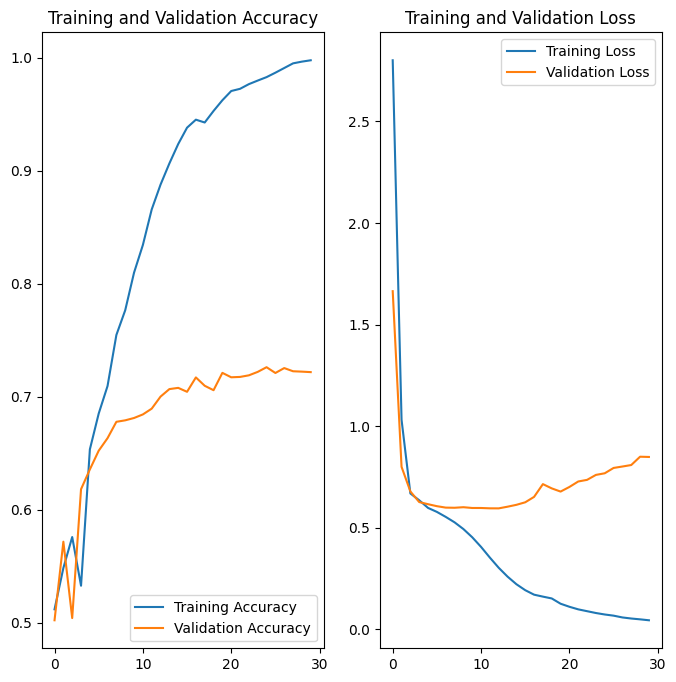

In [23]:
plot_acuracy_loss(history)

## Conclusion model_01

The model clearly fits the training data very well—evidenced by near-perfect training accuracy and a sharply declining training loss. However, the validation accuracy plateaus around the 72% range, and the validation loss starts to increase after an initial decline. This is a classic sign of overfitting: the model memorizes the training set but does not generalize as effectively to unseen data.

# model_02

For model_02, I'll increase the number of kernels from 16 to 32 in the single convolution layer.

In [24]:
model_02 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'), # alterei de 16 para 32
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [25]:
model_02.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [26]:
model_02.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │    10,240,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,240,961 (39.07 MB)

 Trainable params: 10,240,961 (39.07 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs=30
history = model_02.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5109 - loss: 5.0741 - val_accuracy: 0.5191 - val_loss: 1.2466
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.5249 - loss: 1.3526 - val_accuracy: 0.5084 - val_loss: 0.9370
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5386 - loss: 0.8498 - val_accuracy: 0.5838 - val_loss: 0.6647
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5740 - loss: 0.6536 - val_accuracy: 0.6202 - val_loss: 0.6857
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.6412 - loss: 0.6341 - val_accuracy: 0.5666 - val_loss: 0.6461
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.6323 - loss: 0.5989 - val_accuracy: 0.5927 - val_loss: 0.6364
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6382 - loss: 0.5712 - val_accuracy: 0.6396 - val_loss: 0.6400
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.7224 - loss: 0.5445 - val_accuracy: 0.6332 - val_loss: 0

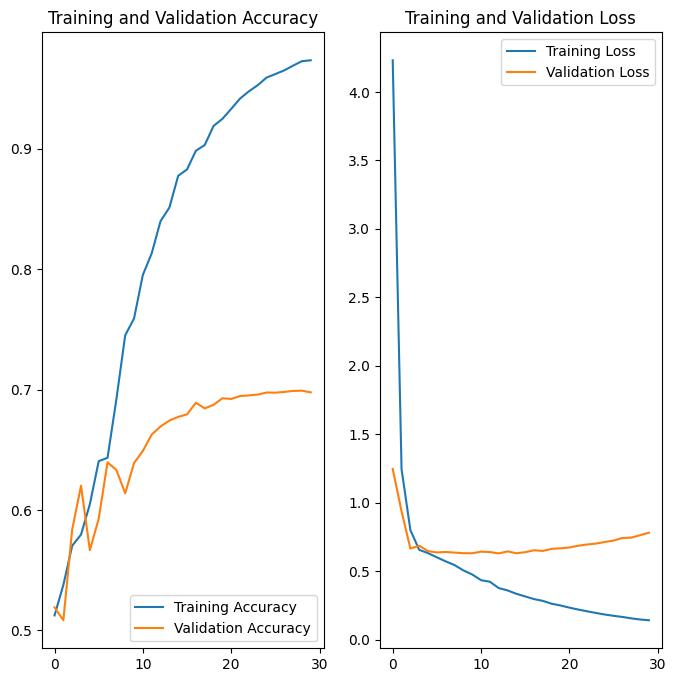

In [28]:
plot_acuracy_loss(history)

## Conclusion model_02

the model is fitting the training data extremely well—evidenced by a high training accuracy (about 97.6%) and a low training loss (0.146). However, the validation accuracy plateaus around 69.8% and the validation loss is relatively high (0.7805). This gap strongly suggests overfitting: the model memorizes the training set patterns but does not generalize as effectively to unseen data.

### model_03

For model_03, I will add another convolutional layer to try to better extract the signal from the training data.

In [29]:
model_03 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'),
    layers.Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear') #como  no compile tem o 'from_logits=True', para otimizar os cálculos podemos manter a output layer como 'linear'
])

In [30]:
model_03.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [31]:
model_03.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │    10,240,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,245,153 (39.08 MB)

 Trainable params: 10,245,153 (39.08 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs=30
history = model_03.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4931 - loss: 4.3548 - val_accuracy: 0.5317 - val_loss: 0.8944
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.5393 - loss: 0.8536 - val_accuracy: 0.5530 - val_loss: 0.7691
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.5656 - loss: 0.7177 - val_accuracy: 0.5021 - val_loss: 0.6907
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.5308 - loss: 0.6640 - val_accuracy: 0.6107 - val_loss: 0.6659
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.5942 - loss: 0.6407 - val_accuracy: 0.6181 - val_loss: 0.6519
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6333 - loss: 0.6157 - val_accuracy: 0.6092 - val_loss: 0.6295
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6688 - loss: 0.5848 - val_accuracy: 0.6177 - val_loss: 0.6379
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.6739 - loss: 0.5674 - val_accuracy: 0.6406 - val_loss: 0

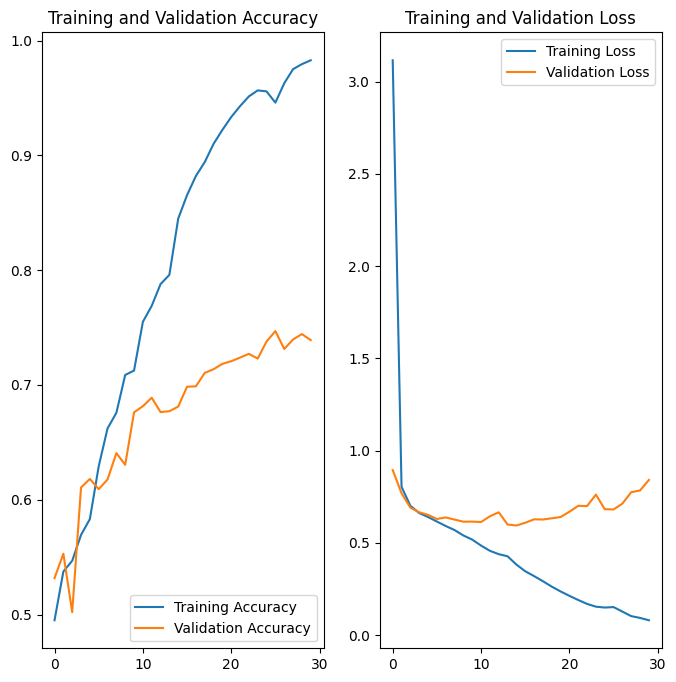

In [33]:
plot_acuracy_loss(history)

## Conclusion model_03

From these results, the model fits the training data very effectively—evidenced by the high training accuracy (~98.24%) and very low training loss (0.0832). Notably, the validation accuracy (73.91%) is higher compared to model_02, suggesting that the additional convolutional layer helps the network extract more useful features. However, the higher validation loss (0.8411) still indicates a clear gap between training and validation performance. In other words, the model is overfitting: it is learning the training data’s patterns extremely well but not generalizing as effectively to unseen data.

### model_04

For model_04, I will add two max pooling layers after the convolutional layers. The addition of these layers helps reduce the spatial dimensions of the feature maps, which decreases computational complexity and mitigates overfitting by reducing the number of parameters.

In [34]:
model_04 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size = (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [35]:
model_04.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [36]:
model_04.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,153 (2.46 MB)

 Trainable params: 645,153 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
epochs=30
history = model_04.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 666ms/step - accuracy: 0.4951 - loss: 0.7513 - val_accuracy: 0.5021 - val_loss: 0.6949
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.4993 - loss: 0.6914 - val_accuracy: 0.5021 - val_loss: 0.6847
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.4993 - loss: 0.6814 - val_accuracy: 0.5021 - val_loss: 0.6533
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.5506 - loss: 0.6379 - val_accuracy: 0.6231 - val_loss: 0.6162
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.6342 - loss: 0.6061 - val_accuracy: 0.6527 - val_loss: 0.6059
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.6528 - loss: 0.5951 - val_accuracy: 0.6852 - val_loss: 0.6162
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6911 - loss: 0.5860 - val_accuracy: 0.6526 - val_loss: 0.5929
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.6922 - loss: 0.5676 - val_accuracy: 0.6894 - val_loss:

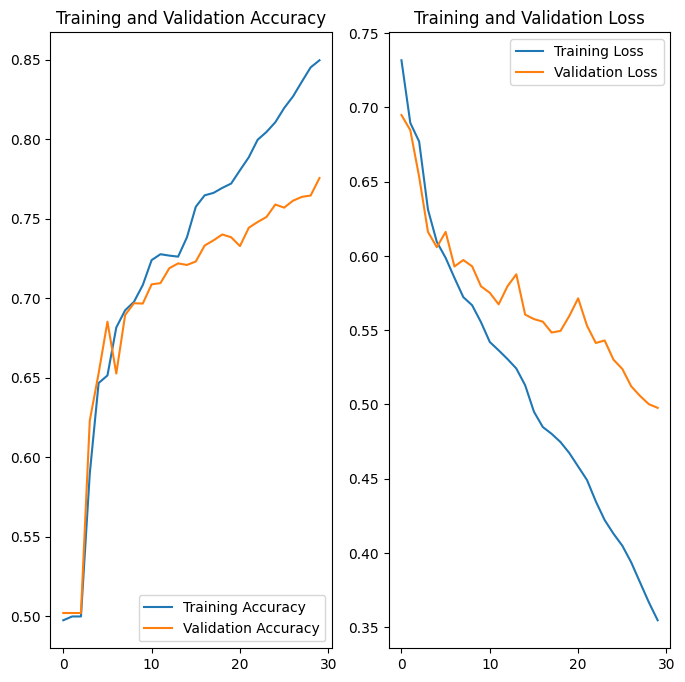

In [38]:
plot_acuracy_loss(history)

## Conclusion model_04

model_04 strikes a decent compromise between memorizing training data and generalizing to unseen data. It is less overfitted than previous models with higher training accuracies but lower validation performance, yet there is still potential to optimize and further improve its generalization.

Apparently, the metrics could improve if we continued training for more epochs.

### model_05

For model_05, I will change the kernel size from (3,3) to (5,5). This modification aims to capture a larger spatial context in each convolutional operation.

In [39]:
model_05 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size= (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size= (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [40]:
model_05.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [41]:
model_05.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,113 (2.50 MB)

 Trainable params: 654,113 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
epochs=30
history = model_05.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5075 - loss: 0.7426 - val_accuracy: 0.5021 - val_loss: 0.6918
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.4993 - loss: 0.6902 - val_accuracy: 0.5021 - val_loss: 0.6809
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.4994 - loss: 0.6731 - val_accuracy: 0.5472 - val_loss: 0.6541
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.5732 - loss: 0.6432 - val_accuracy: 0.6256 - val_loss: 0.6265
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.6299 - loss: 0.6192 - val_accuracy: 0.6130 - val_loss: 0.6178
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.6381 - loss: 0.6048 - val_accuracy: 0.6721 - val_loss: 0.6248
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.6694 - loss: 0.6019 - val_accuracy: 0.6822 - val_loss: 0.6204
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6944 - loss: 0.5881 - val_accuracy: 0.6709 - val_loss: 0

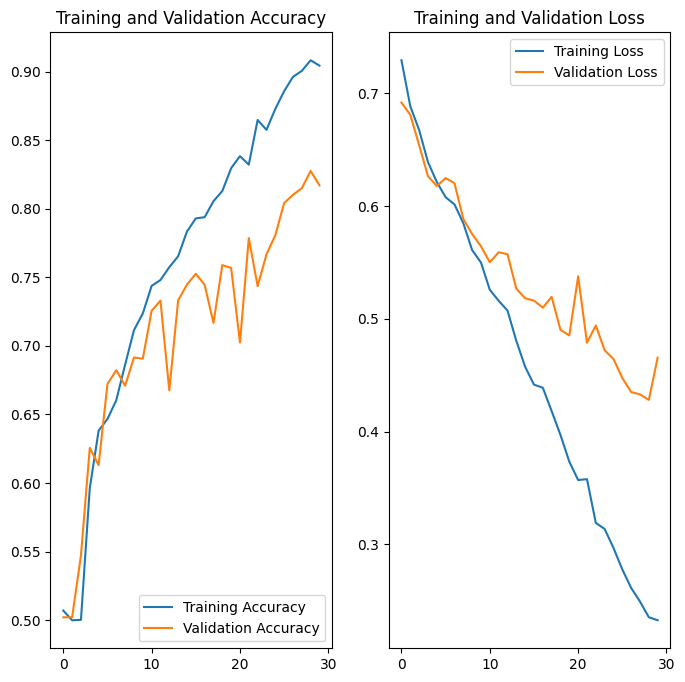

In [44]:
plot_acuracy_loss(history)

## Conclusion model_05

model_05 achieves a better trade-off between training and validation performance, suggesting that the increased kernel size (5×5) helps capture broader contextual features without excessively overfitting.

Apparently, the metrics could improve if we continued training for more epochs.

### model_06

For model_06, I will add a dense layer with 64 neurons.

In [45]:
model_06 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [46]:
model_06.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [47]:
model_06.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,296,225 (4.94 MB)

 Trainable params: 1,296,225 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
epochs=30
history = model_06.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 712ms/step - accuracy: 0.5118 - loss: 0.7023 - val_accuracy: 0.5021 - val_loss: 0.6847
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.5071 - loss: 0.6773 - val_accuracy: 0.5615 - val_loss: 0.6678
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.5902 - loss: 0.6482 - val_accuracy: 0.5821 - val_loss: 0.6406
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.6229 - loss: 0.6187 - val_accuracy: 0.6524 - val_loss: 0.6108
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.6526 - loss: 0.6031 - val_accuracy: 0.6138 - val_loss: 0.6065
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6738 - loss: 0.5821 - val_accuracy: 0.6444 - val_loss: 0.5869
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.6977 - loss: 0.5589 - val_accuracy: 0.7035 - val_loss: 0.5696
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.7112 - loss: 0.5499 - val_accuracy: 0.6592 - val_loss

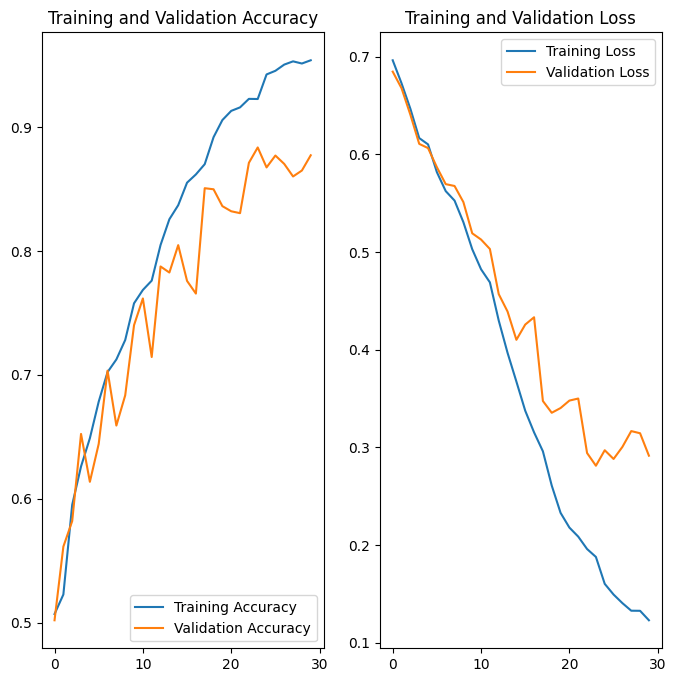

In [49]:
plot_acuracy_loss(history)

## Conclusion model_06

model_06 demonstrates a solid improvement in validation accuracy and maintains a relatively low validation loss, indicating better generalization than many of the previous versions.
The steady decline in both training and validation loss suggests the model is learning meaningful patterns rather than simply memorizing.
The gap between training and validation indicates some overfitting.


### model_07

For model_07, I will add an additional convolutional layer. This extra layer will help the network learn more complex and detailed feature representations.

In [54]:
model_07 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [55]:
model_07.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [56]:
model_07.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,313 (2.51 MB)

 Trainable params: 657,313 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
epochs=30
history = model_07.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 724ms/step - accuracy: 0.4993 - loss: 0.7041 - val_accuracy: 0.5021 - val_loss: 0.6903
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.4993 - loss: 0.6868 - val_accuracy: 0.5084 - val_loss: 0.6643
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.5536 - loss: 0.6555 - val_accuracy: 0.5726 - val_loss: 0.6446
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.6152 - loss: 0.6246 - val_accuracy: 0.5958 - val_loss: 0.6148
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.6623 - loss: 0.5913 - val_accuracy: 0.7118 - val_loss: 0.6023
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.6759 - loss: 0.5829 - val_accuracy: 0.7356 - val_loss: 0.5811
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.7388 - loss: 0.5463 - val_accuracy: 0.7677 - val_loss: 0.5185
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.7692 - loss: 0.4993 - val_accuracy: 0.7974 - val_loss

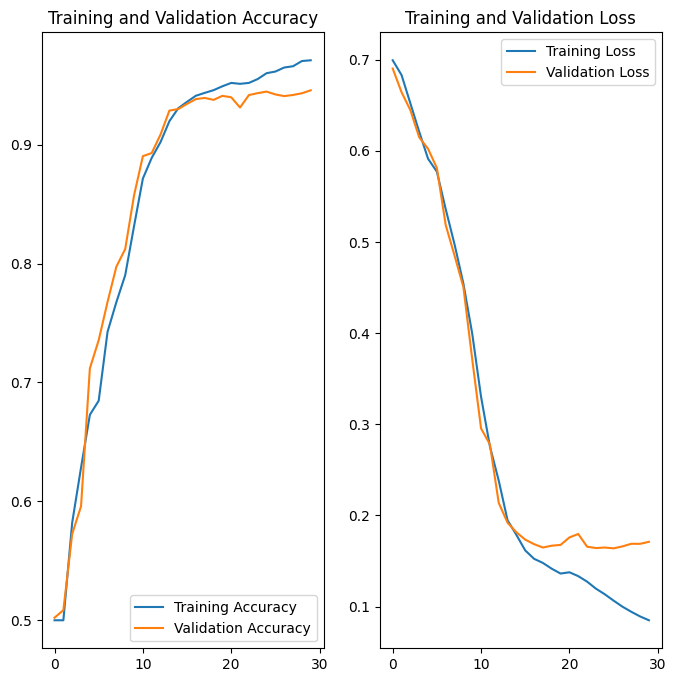

In [58]:
plot_acuracy_loss(history)

## Conclusion model_07

model_07 achieves excellent overall performance, with a training accuracy of 97.17% and a validation accuracy of 94.58%. The training loss (0.0830) is also very close to the validation loss (0.1710), indicating that the model has learned robust patterns from the data rather than simply memorizing the training set.

### model_08

For model_08, I will add an additional convolutional layer. This extra layer will help the network learn more complex and detailed feature representations.

In [61]:
model_08 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [62]:
model_08.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [63]:
model_08.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,329 (2.16 MB)

 Trainable params: 567,329 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
epochs=30
history = model_08.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 732ms/step - accuracy: 0.4993 - loss: 0.6986 - val_accuracy: 0.5021 - val_loss: 0.6915
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.4993 - loss: 0.6875 - val_accuracy: 0.5021 - val_loss: 0.7010
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.5465 - loss: 0.6728 - val_accuracy: 0.5428 - val_loss: 0.6653
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.5751 - loss: 0.6535 - val_accuracy: 0.6329 - val_loss: 0.6454
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.6316 - loss: 0.6302 - val_accuracy: 0.6870 - val_loss: 0.6123
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.6625 - loss: 0.5960 - val_accuracy: 0.7116 - val_loss: 0.5784
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.7133 - loss: 0.5588 - val_accuracy: 0.7646 - val_loss: 0.5156
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.7698 - loss: 0.4942 - val_accuracy: 0.8048 - val_loss

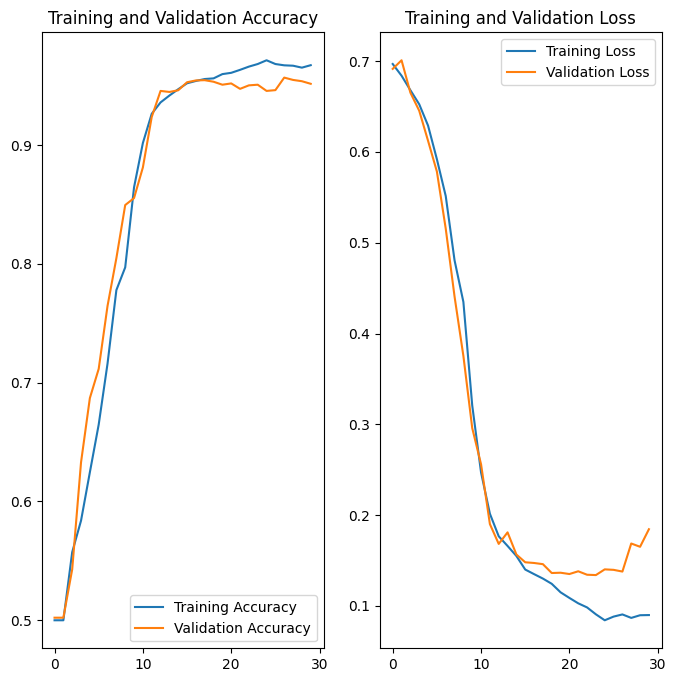

In [65]:
plot_acuracy_loss(history)

## Conclusion model_08

Model_08 shows strong performance with a training accuracy of 96.91% and validation accuracy of 95.17%. The relatively small gap (about 1.7%) between these accuracies indicates that the model generalizes well and is not overfitting excessively.
Although the gap between training and validation performance is small, some slight overfitting may still exist.

### model_09

For model_09, I will change the activation from linear to sigmoid, given that we are dealing with a binary classification problem.

In [67]:
model_09 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [68]:
model_09.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [69]:
model_09.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,329 (2.16 MB)

 Trainable params: 567,329 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
epochs=30
history = model_09.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 586ms/step - accuracy: 0.5063 - loss: 0.6999 - val_accuracy: 0.5021 - val_loss: 0.6921
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.5191 - loss: 0.6902 - val_accuracy: 0.6323 - val_loss: 0.6733
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.6270 - loss: 0.6640 - val_accuracy: 0.6491 - val_loss: 0.6365
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step - accuracy: 0.6551 - loss: 0.6272 - val_accuracy: 0.6744 - val_loss: 0.6045
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - accuracy: 0.6454 - loss: 0.6359 - val_accuracy: 0.6438 - val_loss: 0.6309
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 263ms/step - accuracy: 0.6611 - loss: 0.6120 - val_accuracy: 0.6912 - val_loss: 0.5814
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.7206 - loss: 0.5614 - val_accuracy: 0.7409 - val_loss: 0.5387
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.7665 - loss: 0.5033 - val_accuracy: 0.7969 - val_loss:

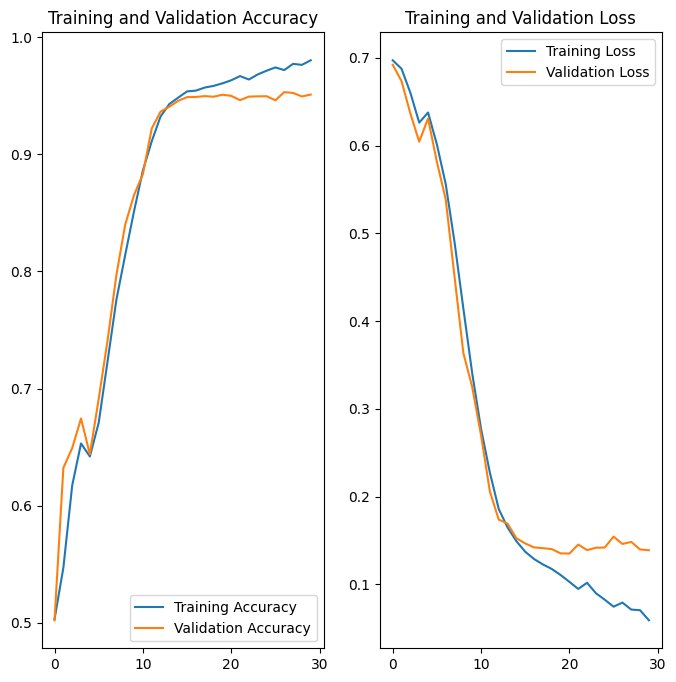

In [71]:
plot_acuracy_loss(history)

## Conclusion model_09

Model_09 demonstrates very strong performance, with a training accuracy of 98.01% and a validation accuracy of 95.10%. The relatively small gap of about 3% between training and validation accuracy indicates that the model is generalizing well and not excessively overfitting.

### model_10

For model_10, I will add another convolutional layer.

In [72]:
model_10 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [73]:
model_10.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [74]:
model_10.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 6, 6, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,329 (4.73 MB)

 Trainable params: 1,239,329 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
epochs=30
history = model_10.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 720ms/step - accuracy: 0.5093 - loss: 0.6918 - val_accuracy: 0.5904 - val_loss: 0.6698
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.5804 - loss: 0.6955 - val_accuracy: 0.6302 - val_loss: 0.6877
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.6401 - loss: 0.6863 - val_accuracy: 0.6082 - val_loss: 0.6766
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6270 - loss: 0.6698 - val_accuracy: 0.5733 - val_loss: 0.6787
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.6101 - loss: 0.6659 - val_accuracy: 0.5984 - val_loss: 0.6619
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.6410 - loss: 0.6373 - val_accuracy: 0.6727 - val_loss: 0.6234
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step - accuracy: 0.6871 - loss: 0.6015 - val_accuracy: 0.6717 - val_loss: 0.6196
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.7185 - loss: 0.5708 - val_accuracy: 0.7225 - val_loss

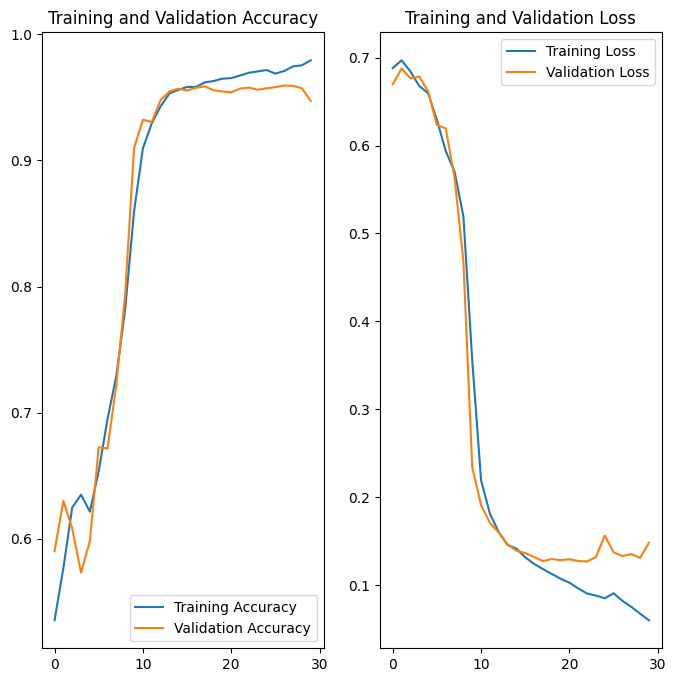

In [77]:
plot_acuracy_loss(history)

## Conclusion model_10

Model_10 demonstrates strong performance with a training accuracy of 98.00% and a validation accuracy of 94.71%. The difference of about 3% between these accuracies indicates some overfitting

### model_11

For model_11, I will add a dropout layer. This technique randomly disables a fraction of neurons during training, preventing the network from overly relying on specific features. As a result, the model learns more robust, generalized representations, which helps reduce overfitting.

In [78]:
model_11 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(64, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(128, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(256, kernel_size = (5,5), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.01),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.01),
    layers.Dense(1, activation='sigmoid')
])

In [79]:
model_11.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [80]:
model_11.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 6, 6, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,329 (4.73 MB)

 Trainable params: 1,239,329 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
epochs=30
history = model_11.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5251 - loss: 0.6934 - val_accuracy: 0.6418 - val_loss: 0.6573
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.6468 - loss: 0.6506 - val_accuracy: 0.7143 - val_loss: 0.6171
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.7180 - loss: 0.5962 - val_accuracy: 0.7473 - val_loss: 0.5394
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.7601 - loss: 0.5257 - val_accuracy: 0.7972 - val_loss: 0.4388
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.8189 - loss: 0.4111 - val_accuracy: 0.8821 - val_loss: 0.2813
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.8946 - loss: 0.2622 - val_accuracy: 0.9339 - val_loss: 0.1934
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.9358 - loss: 0.1848 - val_accuracy: 0.9449 - val_loss: 0.1752
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.9439 - loss: 0.1669 - val_accuracy: 0.9452 - val_loss: 0

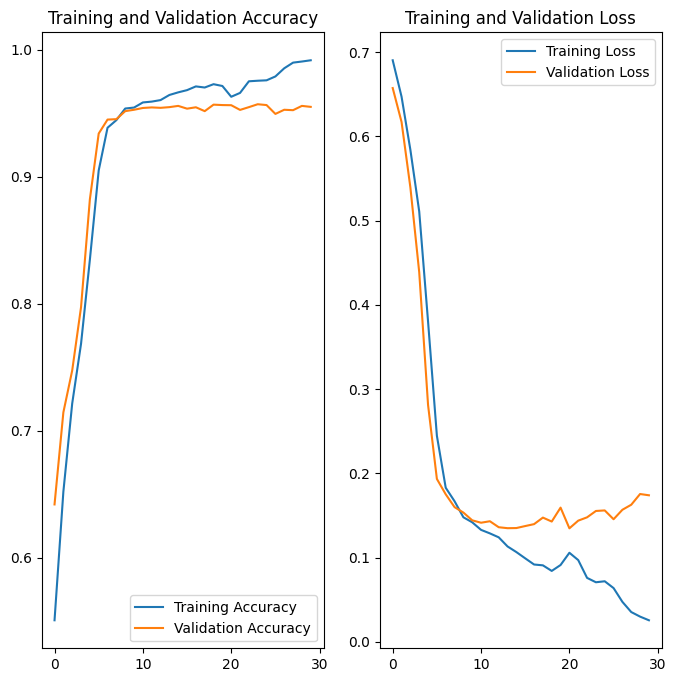

In [82]:
plot_acuracy_loss(history)

## Conclusion model_11

Model_11 exhibits very strong performance, achieving a training accuracy of 99.12% and a validation accuracy of 95.49%.

With near-perfect training accuracy, the model does still overfit to some degree, but the validation accuracy remains strong, demonstrating good generalization.

### model_12


For model_12, I will add L2 regularization. This technique penalizes large weight values by adding the sum of squared weights to the loss function, which encourages the model to learn smaller, more robust weights that generalize better. As a result, it helps reduce overfitting and often improves performance on unseen data.


In [99]:
kernel_regularizer = tf.keras.regularizers.L2(0.01)

In [102]:
model_12 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(64, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(128, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(256, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.01),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.01),
    layers.Dense(1, activation='sigmoid')
])

In [103]:
model_12.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [104]:
model_12.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)              │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 6, 6, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,329 (4.73 MB)

 Trainable params: 1,239,329 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
epochs=30
history = model_12.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5165 - loss: 3.3724 - val_accuracy: 0.5827 - val_loss: 1.9618
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.5789 - loss: 1.7073 - val_accuracy: 0.6046 - val_loss: 1.1465
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6036 - loss: 1.0686 - val_accuracy: 0.5786 - val_loss: 0.9018
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.5986 - loss: 0.8694 - val_accuracy: 0.5511 - val_loss: 0.8198
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.5570 - loss: 0.8030 - val_accuracy: 0.6249 - val_loss: 0.7515
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.6303 - loss: 0.7452 - val_accuracy: 0.5081 - val_loss: 0.7662
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.5172 - loss: 0.7617 - val_accuracy: 0.5021 - val_loss: 0.7532
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.5396 - loss: 0.7497 - val_accuracy: 0.5975 - val_loss: 0

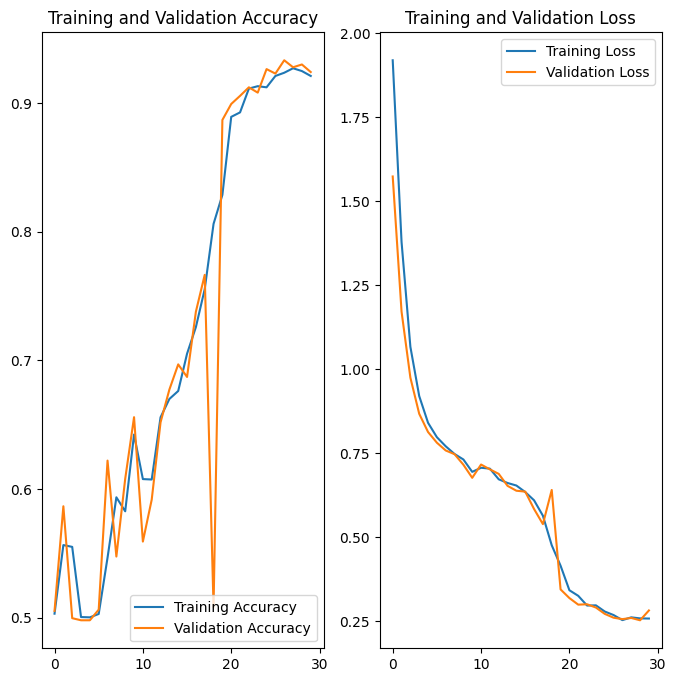

In [94]:
plot_acuracy_loss(history)

## Conclusion model_12

Model_12 achieves a very tight alignment between training and validation performance

L2 regularization appears successful in keeping the weights smaller and in controlling overfitting.

The validation accuracy remains below our target, indicating that further improvements are needed. One possible approach is to increase the number of epochs, allowing the model more time to learn and potentially yield better results. This is something we will implement in the next iteration.

# model_13

For model_13, I will remove one convolutional layer and increase the number of epochs to 45.

In [111]:
model_13 = Sequential([
    layers.Input(shape=(100,100,3)),
    layers.Conv2D(16, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(32, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(64, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Conv2D(128, kernel_size = (5,5), padding='same', activation='relu', kernel_regularizer=kernel_regularizer),
    layers.MaxPooling2D(),
    layers.Dropout(0.01),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.01),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.01),
    layers.Dense(1, activation='sigmoid')
])

In [112]:
model_13.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

In [113]:
model_13.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 100, 100, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 50, 50, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 25, 25, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 12, 12, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,329 (2.16 MB)

 Trainable params: 567,329 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
epochs=45
history = model_13.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 964ms/step - accuracy: 0.5141 - loss: 2.0532 - val_accuracy: 0.6089 - val_loss: 1.5428
Epoch 2/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.5998 - loss: 1.4222 - val_accuracy: 0.5831 - val_loss: 1.1104
Epoch 3/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.5984 - loss: 1.0506 - val_accuracy: 0.5630 - val_loss: 0.9149
Epoch 4/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.5998 - loss: 0.8770 - val_accuracy: 0.6199 - val_loss: 0.7976
Epoch 5/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6304 - loss: 0.7804 - val_accuracy: 0.6300 - val_loss: 0.7465
Epoch 6/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.6501 - loss: 0.7333 - val_accuracy: 0.6365 - val_loss: 0.7153
Epoch 7/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.6582 - loss: 0.7016 - val_accuracy: 0.6774 - val_loss: 0.6823
Epoch 8/45
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.6747 - loss: 0.6758 - val_accuracy: 0.7060 - val_loss

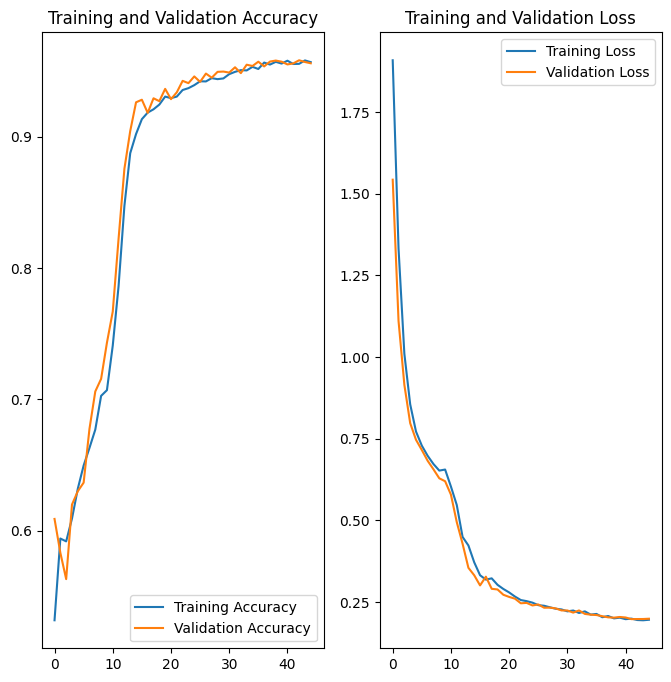

In [115]:
plot_acuracy_loss(history)

## Conclusion model_13

Model_13 strikes a strong balance between complexity and training duration, achieving near-parity between training and validation metrics and demonstrating excellent generalization performance.

Simplifying the architecture (Removing a Convolutional Layer) can reduce the risk of overfitting. The results suggest that the reduced network depth is sufficient to learn robust features for this task.


# The utility of the model created


 This project aims to provide a robust and scalable tool for the classification of malaria-infected cells. The ultimate goal is to enhance diagnostic efficiency and accuracy, particularly in regions that are most affected by malaria, thereby contributing to better health outcomes and a reduction in the global malaria burden.

## Future work

- Predict for the test set;
- k-fold Cross Validation
- Add other metrics like recall, precision, and F1 score;
- Develop a confusion matrix;
- Deploy the model to a web application, such as Streamlit.